In [1]:
import numpy as np
import matplotlib.pyplot as plt
from EMAN2 import *

In [2]:
#### select one GPU when multiple GPUs are present
os.environ["CUDA_VISIBLE_DEVICES"]='0' 

#### do not occupy the entire GPU memory at once
##   seems necessary to avoid some errors...
os.environ["TF_FORCE_GPU_ALLOW_GROWTH"]='true' 

#### finally initialize tensorflow
import tensorflow as tf

In [3]:
#### we will import some functions from e2gmm_refine later
emdir=e2getinstalldir()
sys.path.insert(0,os.path.join(emdir,'bin'))

#### need to unify the float type across tenforflow and numpy
##   in theory float16 also works but it can be unsafe especially when the network is deeper...
floattype=np.float32

In [4]:
#### load particles and prepare some parameters
from e2gmm_refine import load_particles, set_indices_boxsz
fname="gmm_04/ptcls_small_even.lst"

##  Fourier box size. will shrink particles accordingly
maxboxsz=48 

##   load metadata first
e=EMData(fname, 0, True)
raw_apix, raw_boxsz = e["apix_x"], e["ny"]
data_cpx, xfsnp = load_particles(fname, maxboxsz, shuffle=False)

print("Image size: ", data_cpx[0].shape)

##   set up fourier indices for image generation/clipping later
##   params is a dictionay that saves matrices for Fourier indexing
apix=raw_apix*raw_boxsz/maxboxsz
clipid=set_indices_boxsz(data_cpx[0].shape[1], apix, True)
params=set_indices_boxsz(maxboxsz)

##   create an empty options object that is needed for some functions in e2gmm_refine
options=type('options', (object,), {})()
options.sym="c1"

Loading 62450 particles of box size 128. shrink to 48
62450/62450      
Data read complete
Image size:  (62450, 48, 25)


In [5]:
#### load the Gaussian model produced by e2gmm_refine.py
from e2gmm_refine import get_clip

pts=np.loadtxt("gmm_04/model_gmm_even.txt").astype(floattype)
print("Gaussian model shape: ", pts.shape)

##   turn model to tensorflow format
pts=tf.constant(pts[None,:,:])

Gaussian model shape:  (1950, 5)


0.25550684


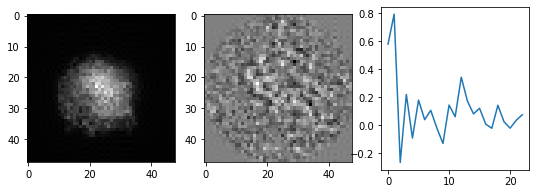

In [6]:
#### now generate some images to make sure everything is working properly
from e2gmm_refine import pts2img, calc_frc

sz=params["sz"]    ## size of image
bsz=8              ## batch size

##   generate a batch of projection images from the GMM at neutral state
##   pts2img produce complex images in (real, imag) format
##   turn them into complex numbers and IFT to get the real images
ptsx=tf.Variable(tf.repeat(pts, bsz, axis=0))
imgs_real, imgs_imag=pts2img(ptsx, xfsnp[:bsz], params, lp=.05)
imgs_cpx=imgs_real.numpy().astype(floattype)+1j*imgs_imag.numpy().astype(floattype)
imgs_out=np.fft.irfft2(imgs_cpx)

##   just show one projection-particle comparison
ii=1
plt.figure(figsize=(9,3))
plt.subplot(1,3,1)
plt.imshow(imgs_out[ii], cmap='gray')

##   get the complex particle image and IFT to real space
dcpx=(data_cpx[0][:bsz], data_cpx[1][:bsz])
dcpx=get_clip(dcpx, sz, clipid)
dcpx_out=np.fft.irfft2(dcpx[0].numpy()+1j*dcpx[1].numpy())

plt.subplot(1,3,2)
plt.imshow(dcpx_out[ii], cmap='gray')

##   calculate FRC between particle and projection
##   the calc_frc function takes complex images in (real, imag) format
frc=calc_frc(dcpx, (imgs_real, imgs_imag), params["rings"], True)
plt.subplot(1,3,3)
plt.plot(frc[ii][1:])
fval=calc_frc(dcpx, (imgs_real, imgs_imag), params["rings"])
print(np.mean(fval))

Instructions for updating:
Use tf.identity instead.
 7807/7807 : 0.3408         mean score: 0.214


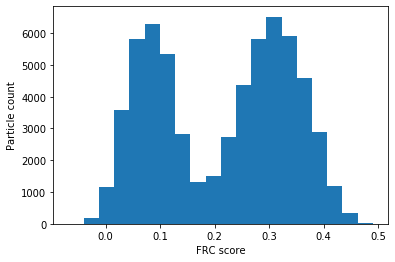

In [7]:
#### calculate d(FRC)/d(GMM) for each particle
##   this will be the input for the deep network in place of the particle images
from e2gmm_refine import calc_gradient

##   shrink particles to the requested size
dcpx=get_clip(data_cpx, params["sz"], clipid)

##   prepare training set to be fed into the function
trainset=tf.data.Dataset.from_tensor_slices((dcpx[0], dcpx[1], xfsnp))
trainset=trainset.batch(bsz)
allscr, allgrds=calc_gradient(trainset, pts, params, options)

##   histogram FRC for each particle
plt.hist(allscr, 20);
plt.xlabel("FRC score");
plt.ylabel("Particle count");

In [19]:
#### There should be a clear seperation of good/bad particles from the histogram above
##   here we only use particles above a threshold
bsz=16
ptclidx=allscr>0.15
n=np.sum(ptclidx)//bsz*bsz
scrthr=-np.sort(-allscr)[n]
ptclidx=allscr>scrthr
print("Keep {} particles, average FRC {:.2f}".format(np.sum(ptclidx), np.mean(allscr[ptclidx])))

Keep 37584 particles, average FRC 0.30


In [20]:
#### now build the deep networks and do some test
from e2gmm_refine import build_encoder, build_decoder

nmid=4     ## size of latent space
conv=True  ## convolution mode, should be more powerful

##   build the actual network
encode_model=build_encoder(nout=nmid, conv=conv)
decode_model=build_decoder(pts[0].numpy(), ninp=nmid, conv=conv)

##   test the network to make sure they are function properly
##   before training, they should output GMMs that are very close to the neutral GMM
mid=encode_model(allgrds[:bsz])
print("Latent space shape: ", mid.shape)
out=decode_model(mid)
print("Output shape: ",out.shape)
print("Deviation from neutral model: ", np.mean(abs(out-pts)))


Latent space shape:  (16, 4)
Output shape:  (16, 1950, 5)
Deviation from neutral model:  9.060476e-06


In [21]:
#### train the network from the particles
from e2gmm_refine import train_heterg

##   parse parameters as options
options.niter=5                ## number of iterations
options.pas=[0,1,0]             ## mask the (position, amplitude, sigma) of the GMM during training
options.learnrate=1e-4          ## learning rate
# ptclidx=allscr>-1               ## this allows the selection of a subset of particles for training. now used now

##   actual training
i=ptclidx
trainset=tf.data.Dataset.from_tensor_slices((allgrds[i], dcpx[0][i], dcpx[1][i], xfsnp[i]))
trainset=trainset.batch(bsz)

train_heterg(trainset, pts, encode_model, decode_model, params, options)

iter 0, loss : -0.3258    
iter 1, loss : -0.3333    
iter 2, loss : -0.3354    
iter 3, loss : -0.3369    
iter 4, loss : -0.3384    


(37584, 4)


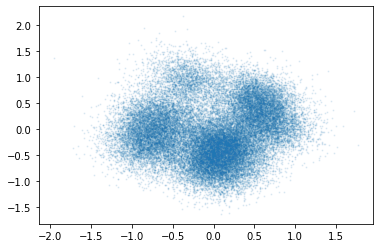

In [25]:
#### compute the conformation of each particle
from e2gmm_refine import calc_conf

##   this is a 4D latent space and can be hard to visualize
mid=calc_conf(encode_model, allgrds[ptclidx])
print(mid.shape)
plt.scatter(mid[:,0], mid[:,1],s=1,alpha=.1);

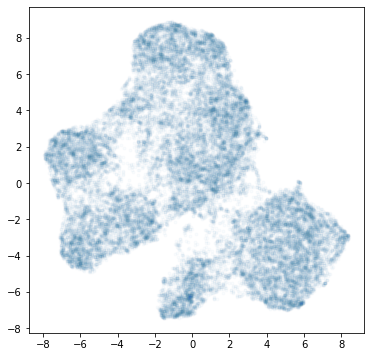

In [26]:
#### here reduce dimension of the latent space to 2D using UMAP
##   note that UMAP currently does not come with EMAN and needs to be installed separatecly
##   PCA should also work fine, just the separation between classes won't be as clear
import umap

um=umap.UMAP()
p2=um.fit_transform(mid)
p2-=np.mean(p2, axis=0)
plt.plot(p2[:,0], p2[:,1],'.', alpha=.02);

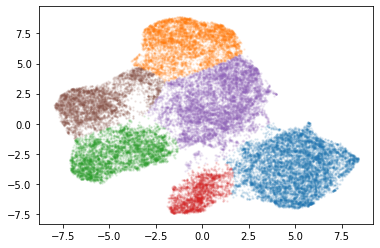

In [42]:
#### classification from UMAP result
##   here we ask for 6 classes, although some minor classes may also present.
from sklearn import mixture
clust = mixture.GaussianMixture(6)
lbs=clust.fit_predict(p2[:,:2])
for l in np.unique(lbs):
    i=lbs==l
    plt.scatter(p2[i,0], p2[i,1],s=2, alpha=.1);

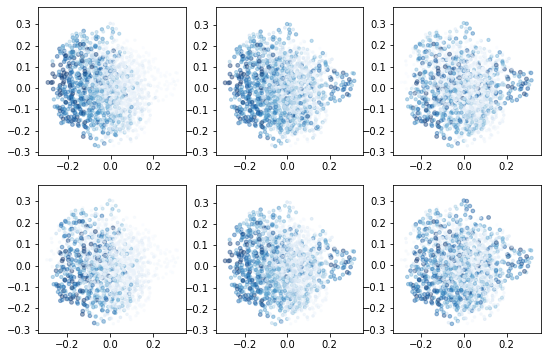

In [43]:
#### plot GMM for each class
pcnt=[]
for l in np.unique(lbs):
    p=mid[lbs==l]
    pcnt.append(np.mean(p, axis=0))

pcnt=np.array(pcnt, dtype=floattype)
pcnt=decode_model(pcnt)    ## go through the decoder to get the Gaussian model
pcnt=pcnt.numpy()

plt.figure(figsize=(9,6))
for i,p in enumerate(pcnt):
    plt.subplot(2,3,i+1)
    plt.scatter(pts[0,:,0], pts[0,:,1], s=p[:,3]*10+5, c=p[:,3]*10, alpha=.4, cmap="Blues")
    plt.axis("square")

In [46]:
#### generate particles subsets from classification
from EMAN2_utils import load_lst_params, save_lst_params
ptclinfo=load_lst_params(fname)
ptclinfo=[p for i,p in enumerate(ptclinfo) if ptclidx[i]]

for l in np.unique(lbs):
    cls=(lbs==l)
    psave=[p for i,p in enumerate(ptclinfo) if cls[i]]
    print("Class {} : {} particles".format(l, len(psave)))
    save_lst_params(psave, "gmm_06/ptcl_cls_{:02d}.lst".format(l))

Class 0 : 9788 particles
Class 1 : 5882 particles
Class 2 : 5468 particles
Class 3 : 2663 particles
Class 4 : 9109 particles
Class 5 : 4674 particles


In [58]:
#### reconstruct particles for each class
for i in np.unique(lbs):
    launch_childprocess("e2spa_make3d.py --input gmm_06/ptcl_cls_{:02d}.lst --output gmm_06/threed_cls_{:02d}.hdf --keep 1 --parallel thread:12 --setsf sf_lp.txt".format(i,i))

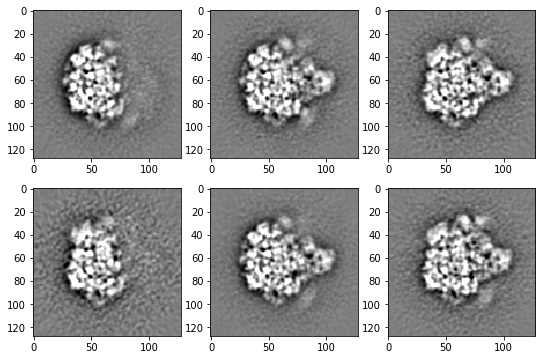

In [64]:
#### look at the 3d map from each class
##   this should be similar to the Gaussian model of each class
plt.figure(figsize=(9,6))

for i in np.unique(lbs):
    e=EMData("gmm_06/threed_cls_{:02d}.hdf".format(i))
    e=e.numpy().copy()
    e=np.mean(e, axis=0)
    plt.subplot(2,3,i+1)
    s=np.std(e)*3
    plt.imshow(e, cmap='gray',vmax=s, vmin=-s)

Number of Gaussian selected:  308


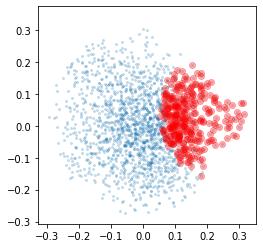

In [117]:
#### now focus on one specific domain to look at the continuous movement
##   here we manualy define the coordinates of the domain and select Gaussian around it
p=pts[0].numpy()
plt.scatter(p[:,0], p[:,1],s=4, alpha=.2)
d=np.linalg.norm(p[:,:3]-[.3,0.05,0.1], axis=1)
imsk=d<.25
print("Number of Gaussian selected: ",np.sum(imsk))
plt.scatter(p[imsk,0], p[imsk,1],c='r', alpha=.3)
plt.axis("square");

In [118]:
#### since not all particles contain the target domain, here we need to filter out particles without it
##   now compute gaussian model for every particle

mout=[]
b=1000
for i in range(len(mid)//b+1):
    a=mid[i*b:(i+1)*b]
    m=decode_model(a)
    mout.append(m.numpy().copy())
    
mout=np.concatenate(mout, axis=0)
print("Model output shape:",mout.shape)

Model output shape: (37584, 1950, 5)


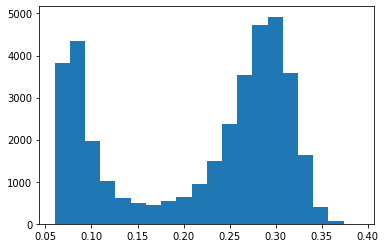

In [77]:
#### There should be a bi-model distribution for the Gaussian intensity of the domain

c=np.mean(mout[:, imsk, 3], axis=1)
plt.hist(c,20);

In [85]:
#### only keep particles that contain the target domain
cthr=0.2
i=np.arange(len(xfsnp))
i=i[ptclidx][c>cthr]
ptclidx_focus=np.zeros(len(xfsnp), dtype=bool)
ptclidx_focus[i]=True
print("Keeping {} particles".format(np.sum(ptclidx_focus)))

Keeping 24034 particles


In [86]:
#### build another encoder-decoder pair for the continuous movement
encode_model_focus=build_encoder(nout=nmid, conv=conv)
decode_model_focus=build_decoder(pts[0].numpy(), ninp=nmid, conv=conv)

##   test the network to make sure they are function properly
##   before training, they should output GMMs that are very close to the neutral GMM
mid=encode_model_focus(allgrds[:bsz])
print("Latent space shape: ", mid.shape)
out=decode_model_focus(mid)
print("Output shape: ",out.shape)
print("Deviation from neutral model: ", np.mean(abs(out-pts)))

Latent space shape:  (16, 4)
Output shape:  (16, 1950, 5)
Deviation from neutral model:  4.1922967e-06


In [90]:
#### build training set for the subset of particles
i=ptclidx_focus
trainset=tf.data.Dataset.from_tensor_slices((allgrds[i], dcpx[0][i], dcpx[1][i], xfsnp[i]))
trainset=trainset.batch(bsz)

In [91]:
#### customized training function
##   similar to train_heterog from e2gmm_refine, but combine the two pairs of encoder-decoders
npt=pts.shape[1]
pas=[1,0,0]
pas_focus=tf.constant(np.array([pas[0],pas[0],pas[0],pas[1],pas[2]], dtype=floattype))

pas=[0,1,0]
pas_raw=tf.constant(np.array([pas[0],pas[0],pas[0],pas[1],pas[2]], dtype=floattype))

## initialize optimizer
opt=tf.keras.optimizers.Adam(learning_rate=options.learnrate)
wts=encode_model_focus.trainable_variables + decode_model_focus.trainable_variables
nbatch=0
for t in trainset: nbatch+=1

## Training
allcost=[]
for itr in range(options.niter):

    cost=[]
    for grd,pjr,pji,xf in trainset:
        pj_cpx=(pjr, pji)
        with tf.GradientTape() as gt:
            ## from gradient input to the latent space
            conf=encode_model_focus(grd, training=True)
            
            ## regularization of the latent layer range
            ## ideally the output is within a 1-radius circle
            ## but we want to make the contraint more soft so it won't affect convergence
            cl=tf.math.sqrt(tf.reduce_sum(conf**2, axis=1))
            cl=tf.reduce_mean(tf.maximum(cl-1,0))
            
            ## preturb the conformation by a random value
            ## similar to the variational autoencoder, but we do not train the sigma of the random value here
            ## since we control the radius of latent space already, this seems enough
            conf=.1*tf.random.normal(conf.shape)+conf
            pout=decode_model_focus(conf, training=True)
            
            ## mask out the target columns based on --pas
            p0=tf.zeros((xf.shape[0],npt, 5))+pts
            pout=pout*pas_focus+p0*(1-pas_focus)
            
            ## mask out only domain of interest
            pout=pout*imsk[None,:,None]+p0*(1-imsk[None,:,None]) 
            
            ## combine this with the model from the previous networks
            cfraw=encode_model(grd, training=False)
            praw=decode_model(cfraw, training=False)
            pout=praw*pas_raw+pout*(1-pas_raw)
            
            ## finally generate images and calculate frc
            imgs_cpx=pts2img(pout, xf, params, sym=options.sym)
            fval=calc_frc(pj_cpx, imgs_cpx, params["rings"])
            loss=-tf.reduce_mean(fval)+cl*1e-2

        cost.append(loss)
        grad=gt.gradient(loss, wts)
        opt.apply_gradients(zip(grad, wts))

        sys.stdout.write("\r {}/{}\t{:.3f}         ".format(len(cost), nbatch, loss))
        sys.stdout.flush()

    sys.stdout.write("\r")

    print("iter {}, loss : {:.4f}".format(itr, np.mean(cost)))
    allcost.append(np.mean(cost))



iter 0, loss : -0.3526    
iter 1, loss : -0.3557    
iter 2, loss : -0.3569    
iter 3, loss : -0.3576    
iter 4, loss : -0.3582    


Latent space shape:  (24034, 4)


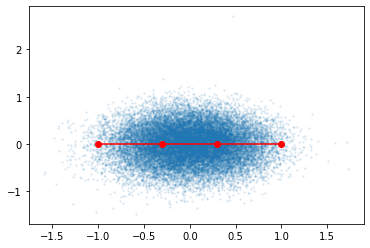

In [94]:
#### now look at the latent space
mid_focus=calc_conf(encode_model_focus, allgrds[ptclidx_focus])
print("Latent space shape: ", mid_focus.shape)

## do pca on the latent space for better visualization
from sklearn.decomposition import PCA

pca=PCA(2)
p3=pca.fit_transform(mid_focus)
plt.scatter(p3[:,0], p3[:,1],s=2,  alpha=.1);


##   draw a line in the PCA space to plot the conformation
cnt=np.zeros((4,2))
cnt[:,0]=[-1, -.3, .3, 1]

plt.plot(cnt[:,0], cnt[:,1], 'ro-')

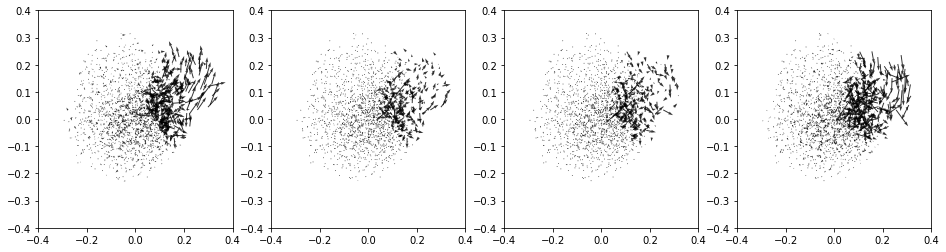

In [100]:
#### look at the GMM conformation along the line in PCA space
pcnt=pca.inverse_transform(cnt)     ## inverse PCA to back to the neural network latent space
pcnt=decode_model_focus(pcnt.astype(floattype))    ## go through the decoder to get the Gaussian model
pcnt=pcnt.numpy()

plt.figure(figsize=(16,4))
for i,p in enumerate(pcnt):
    v=p-pts[0]
    plt.subplot(1,4,i+1)
    plt.quiver(pts[0,:,0], pts[0,:,2], v[:,0], v[:,2], scale=.3, width=5e-3, alpha=.8)
    plt.xlim(-.4,.4)
    plt.ylim(-.4,.4)



In [107]:
#### generate particle subsets from classification
ptclinfo=load_lst_params(fname)
ptclinfo=[p for i,p in enumerate(ptclinfo) if ptclidx_focus[i]]

n=2000
for l,p in enumerate(cnt):
    d=abs(p3[:,0]-p[0])
    thr=np.sort(d)[n]
    cls=d<thr
    psave=[p for i,p in enumerate(ptclinfo) if cls[i]]
    print("Class {} : {} particles".format(l, len(psave)))
    save_lst_params(psave, "gmm_06/ptcl_cls_focus_{:02d}.lst".format(l))

Class 0 : 2000 particles
Class 1 : 2000 particles
Class 2 : 2000 particles
Class 3 : 2000 particles


In [108]:
#### reconstruct particles for each class
for i,p in enumerate(cnt):
    launch_childprocess("e2spa_make3d.py --input gmm_06/ptcl_cls_focus_{:02d}.lst --output gmm_06/threed_cls_focus_{:02d}.hdf --keep 1 --parallel thread:12 --setsf sf_lp.txt".format(i,i))

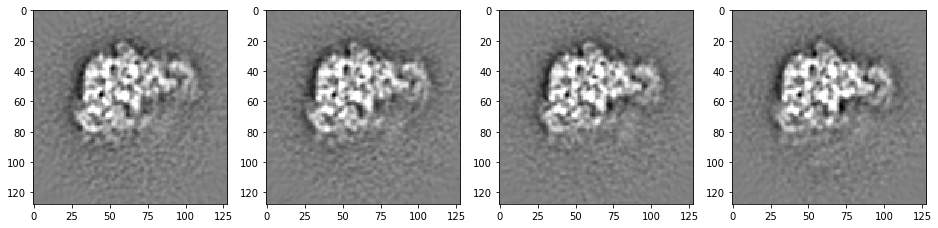

In [114]:
#### look at the 3d map from each class
##   this should be similar to the Gaussian model of each class
plt.figure(figsize=(16,4))

for i,p in enumerate(cnt):
    e=EMData("gmm_06/threed_cls_focus_{:02d}.hdf".format(i))
    e=e.numpy().copy()
    b=25
    e=np.mean(e[:,b:-b], axis=1)
    plt.subplot(1,4,i+1)    
    s=np.std(e)*4
    plt.imshow(e, cmap='gray',vmax=s, vmin=-s)



In [115]:
#### save the trained networks
decode_model.save("gmm_06/model_decode.h5")
encode_model.save("gmm_06/model_encode.h5")

decode_model_focus.save("gmm_06/model_decode_focus.h5")
encode_model_focus.save("gmm_06/model_encode_focus.h5")